In [343]:
import torch
import numpy as np

In [344]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the Data

In [345]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import pandas as pd

# get images and labels from a csv file
def get_data(csv_file):
    df = pd.read_csv(csv_file)
    
    data = [None] * len(df)
    for i, image_data in df.iterrows():
        label = image_data.values[0]
        image = image_data.values[1:].reshape((1, 28, 28)).astype("float32")
        data[i] = (image, label)
        
    return data

In [353]:
# number of subprocesses
num_workers = 0
# number of samples per batch
batch_size = 64
# percentage of training set used for validation
valid_size = 0.2

train_data = get_data("sign-language-mnist/sign_mnist_train.csv")
test_data = get_data("sign-language-mnist/sign_mnist_train.csv")

# get training indices that will be used for the sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
valid_idx, train_idx = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, 
                         num_workers=num_workers)

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", 
           "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

## Visualize a Batch of the Training Data

In [354]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img.squeeze()
    plt.imshow(img, cmap="gray")

# helper function to display a batch of images
def display_batch(images, labels):
    images = images.numpy()
    fig = plt.figure(figsize=(25, 4))
    
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

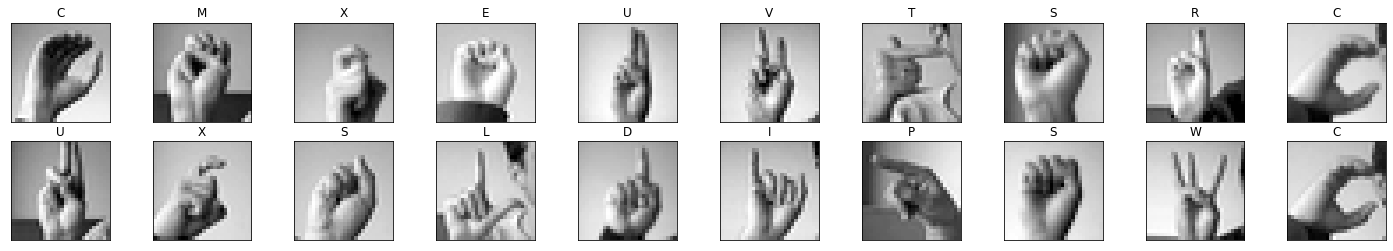

In [355]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
display_batch(images, labels)

## Define the Network Architecture

In [389]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 26)
        
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # sequence of convolutional, max pooling, and fully connected layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc1(x.view(x.shape[0], -1)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [390]:
model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=26, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Train the Network

In [391]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [392]:
num_epochs = 10 # number of epochs to train the model
valid_loss_min = np.Inf # track the change in validation loss

for e in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad() # clear the gradients
        
        # forward pass
        scores = model(images) # compute predicted outputs
        
        # backward pass
        loss = criterion(scores, labels) # compute loss
        loss.backward() # compute gradients
        
        optimizer.step() # optimize parameters
        train_loss += loss.item() * images.size(0) # update training loss
    
    ######################    
    # validate the model #
    ######################
    model.eval()
    
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        # forward pass
        scores = model(images) # compute predicted outputs
        
        loss = criterion(scores, labels) # compute loss
        valid_loss += loss.item() * images.size(0) # update validation loss
            
    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e + 1, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.943743 	Validation Loss: 0.632781
Validation loss decreased (inf --> 0.632781).  Saving model ...
Epoch: 2 	Training Loss: 2.374663 	Validation Loss: 0.629605
Validation loss decreased (0.632781 --> 0.629605).  Saving model ...
Epoch: 3 	Training Loss: 2.102751 	Validation Loss: 0.296833
Validation loss decreased (0.629605 --> 0.296833).  Saving model ...
Epoch: 4 	Training Loss: 0.501565 	Validation Loss: 0.105088
Validation loss decreased (0.296833 --> 0.105088).  Saving model ...
Epoch: 5 	Training Loss: 0.159386 	Validation Loss: 0.172137
Epoch: 6 	Training Loss: 0.091005 	Validation Loss: 0.083347
Validation loss decreased (0.105088 --> 0.083347).  Saving model ...
Epoch: 7 	Training Loss: 0.085032 	Validation Loss: 0.002324
Validation loss decreased (0.083347 --> 0.002324).  Saving model ...
Epoch: 8 	Training Loss: 0.042162 	Validation Loss: 0.000303
Validation loss decreased (0.002324 --> 0.000303).  Saving model ...
Epoch: 9 	Training Loss: 0.043830 

## Test the Trained Network

In [393]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [394]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
for images, labels in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
        
    # forward pass
    scores = model(images) # compute predicted outputs
    
    loss = criterion(scores, labels) # compute loss
    test_loss += loss.item() * images.size(0) # update validation loss
    _, pred = torch.max(scores, 1) # get predicted class
    
    # compare prediction with true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= len(labels):
            break
            
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
# average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000833

Test Accuracy of     A: 100% (1126/1126)
Test Accuracy of     B: 100% (1010/1010)
Test Accuracy of     C: 100% (1144/1144)
Test Accuracy of     D: 99% (1194/1196)
Test Accuracy of     E: 100% (957/957)
Test Accuracy of     F: 100% (1204/1204)
Test Accuracy of     G: 100% (1090/1090)
Test Accuracy of     H: 100% (1013/1013)
Test Accuracy of     I: 100% (1162/1162)
Test Accuracy of     J: N/A (no training examples)
Test Accuracy of     K: 100% (1114/1114)
Test Accuracy of     L: 100% (1241/1241)
Test Accuracy of     M: 100% (1055/1055)
Test Accuracy of     N: 100% (1151/1151)
Test Accuracy of     O: 100% (1196/1196)
Test Accuracy of     P: 100% (1088/1088)
Test Accuracy of     Q: 100% (1279/1279)
Test Accuracy of     R: 100% (1294/1294)
Test Accuracy of     S: 99% (1198/1199)
Test Accuracy of     T: 100% (1186/1186)
Test Accuracy of     U: 100% (1161/1161)
Test Accuracy of     V: 100% (1082/1082)
Test Accuracy of     W: 100% (1225/1225)
Test Accuracy of     X: 100% (